<a href="https://colab.research.google.com/github/MANicholson/Modelling-and-Simulation-of-a-CMOS-Synapse-Implementing-Two-phase-Plasticity/blob/main/Modelling_and_Simulation_of_a_CMOS_Synapse_Implementing_Two_phase_Plasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and imports


In [2]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
!pip install equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00


In [4]:
import jax
import random
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import equinox as eqx
import snntorch as snn
import torch
from snntorch import spikegen
import pandas as pd

# Importing data


In [5]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Importing the data from drive

arr_full_path = '/content/drive/ ... '
df = pd.read_csv(arr_full_path)

arr_test_path = '/content/drive/ ... '
df_test = pd.read_csv(arr_test_path)


## Translating dataset data into input spikes

In [8]:
# Print df to check it is the desired file
print(df)

     label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0        0    0    0    0    0    0    0    0    0    0  ...      0      0   
1        1    0    0    0    0    0    0    0    0    0  ...      0      0   
2        1    0    0    0    0    0    0    0    0    0  ...      0      0   
3        1    0    0    0    0    0    0    0    0    0  ...      0      0   
4        1    0    0    0    0    0    0    0    0    0  ...      0      0   
..     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
163      0    0    0    0    0    0    0    0    0    0  ...      0      0   
164      0    0    0    0    0    0    0    0    0    0  ...      0      0   
165      1    0    0    0    0    0    0    0    0    0  ...      0      0   
166      0    0    0    0    0    0    0    0    0    0  ...      0      0   
167      0    0    0    0    0    0    0    0    0    0  ...      0      0   

     28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0

In [9]:
# Parameters required to produce spike input

spike_length = 150 # Length of time (in ms) each sample is presented to the network
gap_length = 200 # Length of time (in ms) between training samples
Number_synapses = 28*28
dt = 0.001 # Time step
max_spiking_frequency = 40 # Maximum spiking frequency in Hz

In [10]:
# Code to transform datasets into input spike arrays that will be fed to the
# neural network.

def generate_input_spikes(df, spike_length, dt, gap_length, number_synapses):
    def generate_spike_train(value, length, dt):
        frequency = (value / 255) * max_spiking_frequency  # Spiking frequency in Hz
        num_spikes = int(frequency * length * dt)
        spike_train = np.zeros(length)

        if num_spikes > 0:
            if num_spikes >= length:
                spike_train[:] = 1
            else:
                interval = length // num_spikes
                for i in range(num_spikes):
                    spike_train[i * interval] = 1

        return spike_train

    def column_to_spike_array(column):
        spike_array = []
        for value in column:
            spike_train = generate_spike_train(value, spike_length, dt)
            spike_array.append(spike_train)
            spike_array.append(np.zeros(gap_length))
        return np.concatenate(spike_array)

    input_spikes = []
    for column in df.columns[1:]:
        spike_array = jnp.array(column_to_spike_array(df[column]))
        input_spikes.append(spike_array)

    input_spikes = jnp.array(input_spikes)
    input_spikes = input_spikes.reshape(number_synapses, 1, input_spikes.shape[1])

    print("Output array shape:", input_spikes.shape)
    return input_spikes


## Producing the training input

In [11]:
INPUT_SPIKES = generate_input_spikes(df, spike_length, dt, gap_length, Number_synapses)

Output array shape: (784, 1, 58800)


## Producing the test input

In [12]:
INPUT_SPIKES_TEST = generate_input_spikes(df_test, spike_length, dt, gap_length, Number_synapses)

Output array shape: (784, 1, 35000)


## Generating the stimulus input

In [13]:
# Parameters required to produce spike input

stimulus_magnitude = 1e-9
number_secondary_neurons =   2

In [14]:
def create_input_stimuli(df, spike_length, gap_length, stimulus_magnitude, number_secondary_neurons):
    def create_input_stimulus(df, desired_value, stimulus_magnitude):
        result_array = []
        for value in df.iloc[:, 0]:  # Iterate through the first column
            if value == desired_value:
                result_array.extend([stimulus_magnitude] * spike_length)
                result_array.extend([0] * gap_length)
            else:
                result_array.extend([-stimulus_magnitude] * spike_length)
                result_array.extend([0] * gap_length)
        return np.array(result_array)

    stimuli = []
    for i in range(number_secondary_neurons):
        stim = jnp.array([create_input_stimulus(df, i, stimulus_magnitude)])
        stimuli.append(stim)

    return stimuli

stimuli = create_input_stimuli(df, spike_length, gap_length, stimulus_magnitude, number_secondary_neurons)


# Base code for neural network

In [15]:
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np

class many_synapse(eqx.Module):
    tau_DPI: float
    dt: float
    delta_capre: float
    delta_capost: float
    I_TH: float
    I_INDC: float
    I_TAU: float
    ica_0: float
    C: float
    v_H0: float
    I_THPOT: float
    I_THDEP: float
    I_TAILP: float
    I_TAILP_low: float
    I_TAILD: float
    I_TAILD_low: float
    i_hrn: float
    i_hrp: float
    v_h0: float
    V_DD: float
    tau_z_c: float
    z_max: float
    z_min: float
    theta_tag_c: float
    alpha: float
    theta_pro_circuit: float
    z_0: float
    beta: float
    reset_voltage: float
    V_rev: float
    V_spike_threshold: float
    tau_m: float
    R_m: float
    refractory_period: float
    h_0: float = 0.0

    def __call__(self, t_spike_pre_array, I_stim):
        num_input_neurons = t_spike_pre_array.shape[0]

        # Initial states
        i_ca = jnp.zeros((num_input_neurons, 1)) + self.ica_0
        v_h = jnp.zeros((num_input_neurons, 1)) + self.v_h0
        z_ji = jnp.zeros((num_input_neurons, 1)) + self.z_0
        w_ji = jnp.zeros((num_input_neurons, 1)) + self.beta * self.v_h0 + self.beta * self.v_h0 * self.z_0
        V_i = jnp.zeros((1,)) + self.V_rev
        p_i = jnp.zeros((num_input_neurons, 1))
        t_spike_post = 0.0  # Initialize t_spike_post to 0
        refractory_timer = jnp.zeros((1,))

        # Lists to store the results
        V_i_list = []
        t_spike_post_list = []

        def step(carry, input_):
            t_spike_post, i_ca, v_h, z_ji, p_i, w_ji, V_i, refractory_timer = carry
            t_spike_pre, I_stim = input_

            # Code for the neurons in the second layer:..............................

            in_refractory = jnp.squeeze(refractory_timer > 0)
            V_i = jax.lax.cond(in_refractory, lambda _: jnp.array([self.reset_voltage]), lambda _: V_i, operand=None)

            inhibition_condition = jnp.squeeze(jnp.sum(I_stim) < 0)

            reversal_term = (1 / self.tau_m) * (-V_i + self.V_rev)
            pre_spike_contribution = (1 / self.tau_m) * jnp.sum(t_spike_pre * w_ji)
            current_term = (1 / self.tau_m) * jnp.sum((self.R_m * I_stim))

            spike_condition = jnp.squeeze(V_i > self.V_spike_threshold)

            V_i_new = jax.lax.cond(spike_condition, lambda _: jnp.array([self.reset_voltage]), lambda _: V_i + (reversal_term + current_term) * self.dt + pre_spike_contribution, operand=None)
            #For inhibition
            V_i_new = jax.lax.cond(inhibition_condition, lambda _: jnp.array([self.reset_voltage]), lambda _: V_i + (reversal_term + current_term) * self.dt + pre_spike_contribution, operand=None)

            # Update t_spike_post based on spike condition
            t_spike_post_new = jax.lax.cond(spike_condition, lambda _: 1.0, lambda _: 0.0, operand=None)
            t_spike_post_list.append(t_spike_post_new)

            refractory_timer_new = jax.lax.cond(spike_condition, lambda _: jnp.array([self.refractory_period]), lambda _: jax.numpy.maximum(refractory_timer - self.dt, 0), operand=None)

            # Calcium part ---------------------------------------------------------
            dica_dt = (1 / self.tau_DPI) * (-i_ca + self.I_TH * self.I_INDC / self.I_TAU)
            ica_pre_increase = t_spike_pre * self.delta_capre #
            ica_post_increase = t_spike_post_new * self.delta_capost
            i_ca_new = i_ca + dica_dt * self.dt + ica_pre_increase.T + ica_post_increase

            # Early-phase part -----------------------------------------------------
            recovery_condition = jnp.squeeze(v_h > self.v_H0)
            potentiation_condition = jnp.squeeze(i_ca_new > self.I_THPOT)
            depression_condition = jnp.squeeze(i_ca_new > self.I_THDEP)

            i_recovery = jnp.array([jnp.where(recovery_condition, - self.i_hrn, self.i_hrp)])

            i_potentiation = jnp.array([jnp.where(potentiation_condition, self.I_TAILP, self.I_TAILP_low)])

            i_depression = jnp.array([jnp.where(depression_condition, - self.I_TAILD, self.I_TAILD_low)])

            v_h_new = v_h + (1 / self.C) * (i_recovery.T + i_potentiation.T + i_depression.T) * self.dt

            # Ensure v_h_new is not less than 0
            v_h_new = jnp.maximum(v_h_new, 0)

            # Late-phase part ------------------------------------------------------
            epsilon_hi = jnp.abs(v_h_new - self.v_h0)
            condition = jnp.array([jnp.squeeze(epsilon_hi > self.theta_pro_circuit)])
            #p_i = jax.lax.cond(condition, lambda _: self.alpha, lambda _: p_i, operand=None)
            p_i = jnp.where(condition.T, self.alpha, p_i)
            pot_term = p_i * (self.z_max - z_ji) * ((v_h_new - self.v_h0 - self.theta_tag_c) > 0)
            dep_term = p_i * (z_ji - self.z_min) * ((self.h_0 - v_h_new - self.theta_tag_c) > 0)
            dz_dt = (1 / self.tau_z_c) * (pot_term - dep_term)
            z_ji_new = z_ji + dz_dt * self.dt

            # Ensure z_ji_new is not less than 0
            z_ji_new = jnp.maximum(z_ji_new, 0)

            # Total synaptic weight ------------------------------------------------
            w_ji_new = self.beta * v_h_new + self.beta * self.v_h0 * z_ji_new

            V_i_list.append(V_i_new)

            carry = (t_spike_post_new, i_ca_new, v_h_new, z_ji_new, p_i, w_ji_new, V_i_new, refractory_timer_new)
            return carry, (i_ca_new, v_h_new, z_ji_new, w_ji_new, V_i_new, t_spike_post_new)

        carry = (t_spike_post, i_ca, v_h, z_ji, p_i, w_ji, V_i, refractory_timer)
        _, (i_ca, v_h, z_ji, w_ji, V_i, t_spike_post) = jax.lax.scan(step, carry, (t_spike_pre_array.T, I_stim.T))

        time_array = jnp.arange(len((i_ca.T)[0][0])) * self.dt

        return i_ca.T, v_h.T, z_ji.T, w_ji.T, jnp.concatenate(V_i), t_spike_post, time_array


## Differential constants

In [16]:
# Constants

# tc_delay = 0.0188  # Delay of postsynaptic calcium influx after presynaptic spike [s]
c_pre = 0.6  # Presynaptic calcium contribution [in vivo adjusted]
c_post = 0.1655  # Postsynaptic calcium contribution [in vivo adjusted]
tau_c = 0.0488  # Calcium time constant [s]
tau_h = 688.4  # Early-phase time constant [s]
tau_p = 60*60  # Protein time constant [s]
tau_z = 60*60  # Late-phase time constant [s]
# nu_th = 40  # Firing rate threshold for LTP induction [Hz]
gamma_p = 1645.6  # Potentiation rate
gamma_d = 313.1  # Depression rate
theta_p = 0.003 # ALTERED FROM 3  # Calcium threshold for potentiation
theta_d = 0.002 # ALTERED FROM 1.2  # Calcium threshold for depression
# sigma_pl = 2.90436 * 10**(-3)  # Standard deviation for plasticity fluctuations [V]
alpha = 1.0  # Protein synthesis rate
theta_pro = 0.003 #2.10037  * 10**(-3)  # Protein synthesis threshold [V]
theta_tag = 0.840149  * 10**(-3)  # Tagging threshold [V]
h_0 = 4.20075  * 10**(-3) # Median initial excitatory→excitatory coupling strength [V]
h_init = h_0
z_0 = 0.01

# Constants required to combine results from following the logic of the circuits in
# "CMOS circuit design of a multi-timescale learning rule for spiking neural networks" by Jorge Navarro Quijada
# and the results obtained using the differential equations in https://doi.org/10.1007/s12559-022-10021-7

h_max = 10 * 10**(-3) # The maximum value of the early-phase variable [V]
z_max = 1 # The minimum value of the late-phase variable
z_min = - 0.5 # The maximum value of the late-phase variable

beta = 4.6675*10**(-3) # The conversion factor to match the outputs of the two methods

## Circuit constants

In [17]:
# Calcium:
I_INDC = 25 * 10**(-12) # The DC component of the tail current to stimulate the DPI.
# i_pre = 800 * 10**(-12)
# i_post = 200 * 10**(-12)
tau_DPI = 0.00488  # The time constant of the DPI.
I_TH = 10 * 10**(-12) # The current to tune the gain of the DPI.
I_TAU = 20 * 10**(-12) # The current to tune the time constant of the DPI.
ica_0 = 17 * 10**(-12) # The initial calcium concentration current.
delta_capre = 15 * 10**(-12) # The contribution of a presynaptic spike to the calcium concentration current.
delta_capost = 15 * 10**(-12) # The contribution of a postsynaptic spike to the calcium concentration current.


# Early-phase:
tau_h_c = 68.84 # [s] # The early-phase time constant.
C = 1.2215 * 10**(-12) # The capacitance of the capacitor.
v_H0 = 0.9 # The reference value of the early-phase weight voltage.
I_THPOT = 30 * 10**(-12) # CHANGED FROM: 62 * 10**(-12) The early-phase potentiation threshold for the calcium concentration.
I_THDEP = 25* 10**(-12) # CHANGED FROM: 39.5 * 10**(-12) The early-phase depression threshold for the calcium concentration.
I_TAILP = 50 * 10**(-12) # The magnitude of the HIGH potentiation current.
I_TAILP_low = 1.2 * 10**(-15) # The magnitude of the LOW potentiation current.
I_TAILD = 10 * 10**(-12) # CHANGED FROM 10 * 10**(-12) The magnitude of the HIGH depression current.
I_TAILD_low = 1.2 * 10**(-15) # The magnitude of the LOW depression current.
i_hrp = 2.5 * 10**(-15) # The magnitude of the potentiating-recovery current.
i_hrn = 80 * 10**(-15) # The magnitude of the depressing-recovery current.
v_h0 = 900 * 10**(-3) # The initial value of the early-phase weight voltage.
V_DD = 1.8 # The maximum value of the early-phase weight voltage.

# Late phase:
z_0 = 0.0 # The initial late-phase value.
theta_tag_c = 0.0151226 # The tagging threshold for a synaptic tag to be formed.
theta_pro_circuit = 0.01 # The protein capture threshold, for protein capture at a synapse to occur.
tau_z_c = 5 # The late-phase time constant.



beta = 4.6675*10**(-3) # The constant needed to convvert the early-phase voltage given by Jorge's circuit to voltages comparable with Jannik's paper (and the late phase weight).

# Training the neural network

In [18]:
tau_m = 0.01 # The neuron membrane time constant.
V_rev = -0.065 # The reversal voltage.
R_m = 10e6 # The resistance used in the LIF neuron.
reset_voltage = -0.07 # The neuron reset voltage.
V_spike_threshold = 70 # The spiking threshold for the LIF neuron.
refractory_period = 0.0001 # The refractory period following a spike.
dt = 0.001 # Time step

In [19]:
manySynapse = many_synapse(
    tau_DPI, dt, delta_capre, delta_capost, I_TH, I_INDC, I_TAU, ica_0,
    C, v_H0, I_THPOT, I_THDEP, I_TAILP, I_TAILP_low, I_TAILD, I_TAILD_low, i_hrn, i_hrp,
    v_h0, V_DD, tau_z_c, z_max, z_min, theta_tag_c, alpha, theta_pro_circuit, z_0, beta, reset_voltage, V_rev, V_spike_threshold, tau_m, R_m, refractory_period
)

results = []

## Creating arrays with the final weights and plotting synaptic weights

In [20]:
for i, stim in enumerate(stimuli):
    results.append(manySynapse(INPUT_SPIKES, stim))

2


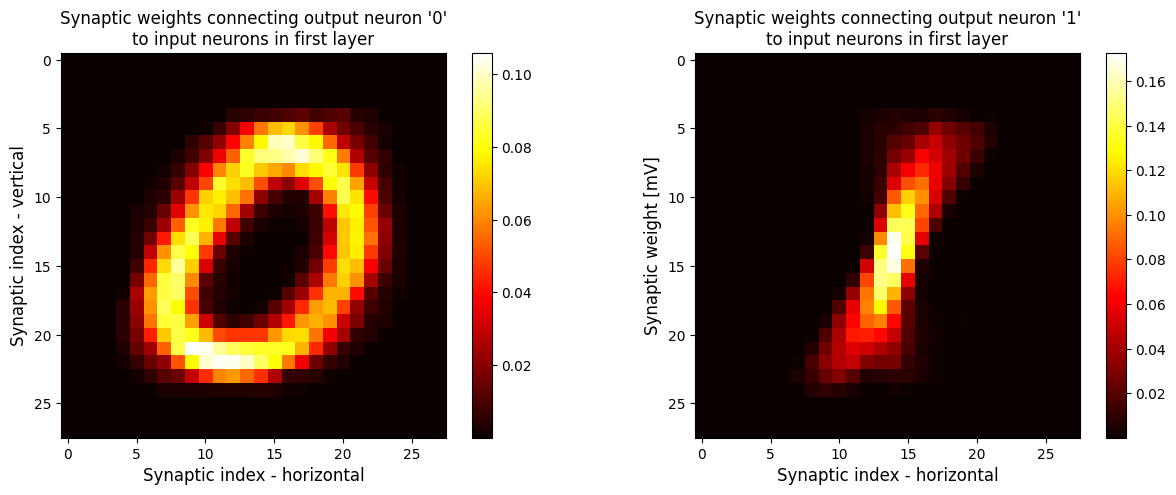

<Figure size 640x480 with 0 Axes>

In [21]:
final_weights = []
for i in range(number_secondary_neurons):
    w_ji = results[i][3]
    final_values = w_ji[-1, :, -1]
    final_weights.append(final_values)

print(len(final_weights))

# Plotting heatmaps
fig, axs = plt.subplots(1, number_secondary_neurons, figsize=(15, 5))

for i, weights in enumerate(final_weights):
    square_grid = weights.reshape((28, 28))

    im = axs[i].imshow(square_grid, cmap='hot', interpolation='nearest')
    axs[i].set_title(f'Synaptic weights connecting output neuron \'{i}\'\nto input neurons in first layer')
    plt.colorbar(im)
    axs[1].set_ylabel('Synaptic weight [mV]', fontsize = 12)
    axs[i].set_xlabel('Synaptic index - horizontal', fontsize = 12)
    axs[0].set_ylabel('Synaptic index - vertical', fontsize = 12)



plt.show()
plt.tight_layout()

# Testing the neural network

In [22]:
class test_Network(eqx.Module):
    tau_DPI: float
    dt: float
    delta_capre: float
    delta_capost: float
    I_TH: float
    I_INDC: float
    I_TAU: float
    ica_0: float
    C: float
    v_H0: float
    I_THPOT: float
    I_THDEP: float
    I_TAILP: float
    I_TAILP_low: float
    I_TAILD: float
    I_TAILD_low: float
    i_hrn: float
    i_hrp: float
    v_h0: float
    V_DD: float
    tau_z_c: float
    z_max: float
    z_min: float
    theta_tag_c: float
    alpha: float
    theta_pro_circuit: float
    z_0: float
    beta: float
    reset_voltage: float
    V_rev: float
    V_spike_threshold: float
    tau_m: float
    R_m: float
    refractory_period: float
    h_0: float = 0.0

    def __call__(self, t_spike_pre_array, w_ji):
        num_input_neurons = t_spike_pre_array.shape[0]

        # Initial states
        V_i = jnp.zeros((1,)) + self.V_rev
        t_spike_post = 0.0  # Initialize t_spike_post to 0
        refractory_timer = jnp.zeros((1,))
        W_ji = w_ji.T

        # Lists to store the results
        V_i_list = []
        t_spike_post_list = []

        def step(carry, input_):
            t_spike_post, V_i, refractory_timer, w_ji = carry
            t_spike_pre = input_

            # Code for the neurons in the second layer:..............................

            in_refractory = jnp.squeeze(refractory_timer > 0)
            V_i = jax.lax.cond(in_refractory, lambda _: jnp.array([self.reset_voltage]), lambda _: V_i, operand=None)

            reversal_term = (1 / self.tau_m) * (-V_i + self.V_rev)
            pre_spike_contribution = (1 / self.tau_m) * jnp.sum(t_spike_pre * W_ji)

            spike_condition = jnp.squeeze(V_i > self.V_spike_threshold)

            V_i_new = jax.lax.cond(spike_condition, lambda _: jnp.array([self.reset_voltage]), lambda _: V_i + (reversal_term) * self.dt + pre_spike_contribution, operand=None)

            # Update t_spike_post based on spike condition
            t_spike_post_new = jax.lax.cond(spike_condition, lambda _: 1.0, lambda _: 0.0, operand=None)
            t_spike_post_list.append(t_spike_post_new)

            refractory_timer_new = jax.lax.cond(spike_condition, lambda _: jnp.array([self.refractory_period]), lambda _: jax.numpy.maximum(refractory_timer - self.dt, 0), operand=None)

            V_i_list.append(V_i_new)

            carry = (t_spike_post_new, V_i_new, refractory_timer_new, w_ji)

            return carry, (V_i_new, t_spike_post_new)

        carry = (t_spike_post, V_i, refractory_timer, w_ji)
        _, (V_i, t_spike_post) = jax.lax.scan(step, carry, (t_spike_pre_array.T))

        time_array = jnp.arange(len((t_spike_post))) * self.dt

        return V_i, t_spike_post, time_array



In [23]:
network_test = test_Network(
    tau_DPI, dt, delta_capre, delta_capost, I_TH, I_INDC, I_TAU, ica_0,
    C, v_H0, I_THPOT, I_THDEP, I_TAILP, I_TAILP_low, I_TAILD, I_TAILD_low, i_hrn, i_hrp,
    v_h0, V_DD, tau_z_c, z_max, z_min, theta_tag_c, alpha, theta_pro_circuit, z_0, beta, reset_voltage, V_rev, V_spike_threshold, tau_m, R_m, refractory_period
)

In [24]:
number_secondary_neurons = len(final_weights)
number_test_samples = len(df_test)
print("number test samples:", number_test_samples)

# Initialize results_matrix with appropriate dimensions
results_matrix = np.zeros((number_secondary_neurons, number_test_samples))

# Run network_test for each final weight
for neuron_idx, final_weight in enumerate(final_weights):
    V_i, t_spike_post, _ = network_test(INPUT_SPIKES_TEST, final_weight/4)

    # Divide t_spike_post into subarrays
    subarray_length = len(t_spike_post) // number_test_samples
    t_spike_post_subarrays = np.array_split(t_spike_post, number_test_samples)

    for row_idx, subarray in enumerate(t_spike_post_subarrays):
        results_matrix[neuron_idx, row_idx] = jnp.sum(subarray)

# Find the secondary neuron that fired the most for each row
most_firing_neurons = np.argmax(results_matrix, axis=0)

print(len(most_firing_neurons)) # Verify length of most_firing_neurons

# Compare with the actual labels
correct_predictions = 0
for row_idx, row in df_test.iterrows():
    true_label = row[0]
    predicted_label = most_firing_neurons[row_idx]
    if predicted_label == true_label:
        correct_predictions += 1

print(most_firing_neurons) # Print most_firing_neurons for debugging
print(correct_predictions) # Print correct_predictions for debugging

# Calculate and print accuracy
accuracy = correct_predictions / number_test_samples
print(f"Accuracy: {accuracy * 100:.2f}%")


number test samples: 100
100
[1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1
 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1
 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0]
93
Accuracy: 93.00%
